<a href="https://colab.research.google.com/github/pskaranth/thelearningcurve/blob/master/DeepLearning/RNN/Transliteration/Transliteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Machine transliteration example.


*  Transliteration from English to Hindi using Encoder-Decoder with attention mechanism.
*  Using RNN as a sequence model for encoding and decoding.


In [2]:
import xml.etree.ElementTree as ET
import re

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/content/drive/MyDrive/Machine Learning/onefourthlabs/pynb_codes/11_ObjectDetection


In [15]:
eng_alphabets ='-'+'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [5]:
# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)

hindi_alphabets  = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabets.insert(0,'-' )
print(hindi_alphabets)
print(len(hindi_alphabets))

['-', 'ऀ', 'ँ', 'ं', 'ः', 'ऄ', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ऌ', 'ऍ', 'ऎ', 'ए', 'ऐ', 'ऑ', 'ऒ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'ऩ', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ऱ', 'ल', 'ळ', 'ऴ', 'व', 'श', 'ष', 'स', 'ह', 'ऺ', 'ऻ', '़', 'ऽ', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॅ', 'ॆ', 'े', 'ै', 'ॉ', 'ॊ', 'ो', 'ौ', '्', 'ॎ', 'ॏ', 'ॐ', '॑', '॒', '॓', '॔', 'ॕ', 'ॖ', 'ॗ', 'क़', 'ख़', 'ग़', 'ज़', 'ड़', 'ढ़', 'फ़', 'य़', 'ॠ', 'ॡ', 'ॢ', 'ॣ', '।', '॥', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९', '॰', 'ॱ', 'ॲ', 'ॳ', 'ॴ', 'ॵ', 'ॶ', 'ॷ', 'ॸ', 'ॹ', 'ॺ', 'ॻ', 'ॼ', 'ॽ', 'ॾ', 'ॿ']
129


In [6]:
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

# Remove all English non-letters
def cleanEnglishVocab(line):
    line = line.replace('-', ' ').replace(',', ' ').replace('/',' ')
    word = non_eng_letters_regex.sub('', line.upper()) #Anything that matches non_eng_letters_regex, substitute with ''
    return word.split()

# Remove all Hindi non-letters
def cleanHindiVocab(line):
    # for char in line:
    #   if char not in hindi_alpha2index :
    #    print(char) # printing special characters
    line = line.replace('-', ' ').replace(',', ' ').replace('/',' ')
    for char in line:
       if char not in hindi_alphabets and char != ' ': #Anything that's in hindi_alpha2index or space, add it to a list
         line = char.replace(char,'')
    return line.split()

In [7]:
def readXml(filename):
        transliterationCorpus = ET.parse(filename).getroot()
        lang1_words = []
        lang2_words = []

        for line in transliterationCorpus:
            wordlist1 = cleanEnglishVocab(line[0].text)# iterating from root.
            wordlist2 = cleanHindiVocab(line[1].text)

            # Skip noisy data
            if len(wordlist1) != len(wordlist2): # in case the number of char in english != hindi, then skip it
                # print('Skipping: ', line[0].text, ' - ', line[1].text)
                continue

            for word in wordlist1:
                lang1_words.append(word)
            for word in wordlist2:
                lang2_words.append(word)

        return list(zip(lang1_words, lang2_words))

In [8]:
td = readXml('NEWS2012TrainingEnHi13937-1563719470862.xml')
print(td[18000:18500])
print(type(td))

[('RAMA', 'रामा'), ('HARE', 'हरे'), ('KRISHNA', 'क़ृष्णा'), ('QUINTA', 'क्विंटा'), ('GIRIDIH', 'गिरिडीह'), ('WILBUR', 'विल्बर'), ('MARDAV', 'मार्दव'), ('SIR', 'सर'), ('RICHARD', 'रिचर्ड'), ('HADLEE', 'हेडली'), ('ATABAQUE', 'अताबैक'), ('ADIDAS', 'एडीडास'), ('PHAZOM', 'फ़ज़ोम'), ('AWAARGI', 'आवारगी'), ('ZENSAR', 'ज़ेन्सार'), ('GUILFORD', 'गल्फोर्ड'), ('CAROL', 'कैरोल'), ('OMAPRAKAASH', 'ओमप्रकाश'), ('CARON', 'कैरोन'), ('JIN', 'जिन'), ('MAO', 'माओ'), ('BUILDING', 'बिल्डिंग'), ('QARAAH', 'कराह'), ('JAIWANTI', 'जयवंती'), ('SUPA', 'सुपा'), ('DAM', 'डैम'), ('AACHAARYASUT', 'आचार्यसुत'), ('FINANCIAL', 'फायनैन्शियल'), ('EXPRESS', 'एक्सप्रेस'), ('LEELA', 'लीला'), ('JOHN', 'जॉन'), ('WAYNE', 'वेन'), ('LEOPARD', 'लियोपार्ड'), ('SHAUN', 'शॉन'), ('GRAF', 'ग्रेफ'), ('FATEH', 'फतेह'), ('KRASHN', 'कृष्ण'), ('PROFESSOR', 'प्रोफेसर'), ('AAQIB', 'आकिब'), ('JAVED', 'जावेद'), ('HIRAA', 'हीरा'), ('LILAC', 'लिलेक'), ('SALEEMAH', 'सलीमाह'), ('VEERESHWAR', 'वीरेश्वर'), ('SANAM', 'सनम'), ('TERI', 'तेरी'), ('KASAM'

In [9]:
train_data = readXml('NEWS2012TrainingEnHi13937-1563719470862.xml')
test_data = readXml('NEWS2012RefEnHi1000-1563719263404.xml')

In [10]:
print(type(train_data))
print(len(test_data))

<class 'list'>
1000


In [11]:
print(train_data[1:10])
data_ = [[ i for i, j in train_data[1:10] ],
       [ j for i, j in train_data[1:10] ]]
# print(data_)
print(list(zip(*train_data[1:10])))
print([ i for i, j in train_data[1:10]])

[('DEOGAN', 'देवगन'), ('ROAD', 'रोड'), ('SHATRUMARDAN', 'शत्रुमर्दन'), ('MAHIJUBA', 'महिजुबा'), ('SABINE', 'सैबिन'), ('BILL', 'बिल'), ('COSBY', 'कॉस्बी'), ('RISHTA', 'रिश्ता'), ('KAGAZ', 'कागज़')]
[('DEOGAN', 'ROAD', 'SHATRUMARDAN', 'MAHIJUBA', 'SABINE', 'BILL', 'COSBY', 'RISHTA', 'KAGAZ'), ('देवगन', 'रोड', 'शत्रुमर्दन', 'महिजुबा', 'सैबिन', 'बिल', 'कॉस्बी', 'रिश्ता', 'कागज़')]
['DEOGAN', 'ROAD', 'SHATRUMARDAN', 'MAHIJUBA', 'SABINE', 'BILL', 'COSBY', 'RISHTA', 'KAGAZ']


### Encoding words

In [12]:
print(train_data[1][0])

DEOGAN


In [16]:
def eng_encoded(word_, device = 'cpu'):
  # print(word_)
  word_ohe = torch.zeros(len(word_)+1,1,len(eng_alphabets)).to(device)
  for index_,char_ in enumerate(word_):    
    pos = eng_alphabets.find(char_)    
    word_ohe[index_][0][pos] = 1
  word_ohe[index_+1][0][0] = 1 # pad
  return word_ohe

In [17]:
eng_enc = eng_encoded(train_data[1][0])
print(eng_enc)

tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [18]:
def hindi_encoded(word_, device = 'cpu'):
  # print(word_)
  hindi_enc = torch.zeros([len(word_)+1,1],dtype=torch.long).to(device)
  for index_, char_ in enumerate(word_):
    #  print(char_)
    pos = hindi_alphabets.index(char_)
    # print(pos)
    hindi_enc[index_][0] = pos 
  hindi_enc[index_+1][0] = 0
  return hindi_enc

In [19]:
hindi_enc = hindi_encoded(train_data[4][1])
print(hindi_enc)

tensor([[47],
        [58],
        [64],
        [29],
        [66],
        [45],
        [63],
        [ 0]])


### Encoder Decoder without Attention


In [20]:
MAX_OUTPUT_CHARS = 30
class Transliteration_EncoderDecoder(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, verbose=False):
        super(Transliteration_EncoderDecoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.decoder_rnn_cell = nn.GRU(output_size, hidden_size)
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        self.verbose = verbose
        
    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        
        # encoder
        out, hidden = self.encoder_rnn_cell(input)
        
        if self.verbose:
            print('Encoder input', input.shape)
            print('Encoder output', out.shape) # includes surrounding chars to get 256
            print('Encoder hidden', hidden.shape)
        
        # decoder
        decoder_state = hidden
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        outputs = []
        
        if self.verbose:
            print('Decoder state', decoder_state.shape)
            print('Decoder input', decoder_input.shape)
        
        for i in range(max_output_chars):
            
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            
            if self.verbose:
                print('Decoder intermediate output', out.shape)
            
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            
            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False           
            max_idx = torch.argmax(out, 2, keepdim=True)            
           
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            # print(out,'out')
            
            # one_hot = torch.zeros(out.shape, device=device)
            one_hot = torch.FloatTensor(out.shape).to(device)
            one_hot.zero_()           
            one_hot.scatter_(2, max_idx, 1)
            # print(one_hot,'scatter')
            
            decoder_input = one_hot.detach()
            
        return outputs

In [75]:
net_wt = Transliteration_EncoderDecoder(len(eng_alphabets), 256, len(hindi_alphabets), verbose=True)

In [34]:
def infer(net, name_,device='cpu'):
    # print(device)
    word_ohe = eng_encoded(name_,device).to(device) 

    # print(word_ohe) 
    # print(type(word_ohe))
    outputs = net(word_ohe,30)
    type(outputs)
    y_pred= []  
    for index, output in enumerate(outputs):
        #  print(torch.argmax(output))
         y_pred.append(hindi_alphabets[torch.argmax(output)])
        #  print(hindi_alphabets[torch.argmax(output)])
    print(y_pred) 
    return outputs 


In [76]:
out = infer(net_wt, 'INDIA', device_gpu) #prints random characters as it is not trained yet
print(len(out))

Encoder input torch.Size([6, 1, 27])
Encoder output torch.Size([6, 1, 256])
Encoder hidden torch.Size([1, 1, 256])
Decoder state torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 129])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])
['ि', 'क', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़', 'फ़']
30


###Train the model

In [26]:
def dataload(train_data, batch_size):
 tl  = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)

 for index, data_ in enumerate(tl):
    eng_batch, hindi_batch = data_
    # print('next')
    return eng_batch, hindi_batch

In [ ]:
# eng_batch, hindi_batch = dataload()

# print(eng_batch[34])

In [ ]:
# batch_input  = torch.utils.data.DataLoader(train_data, 64, shuffle=True)
#  for i, data in enumerate(batch_input):
#         inputs, labels = data
#         print(inputs, ' inp')
#         print(labels,'labels')

In [ ]:
# tl  = torch.utils.data.DataLoader(train_data, 64, shuffle=True)
# dataiter = iter(tl)
# eng_from_batch =[]
# hindi_from_batch = []
# for eng_batch, hindi_batch in dataiter:
#   # print(eng_batch)
#     eng_from_batch.append(eng_batch)
#     hindi_from_batch.append(hindi_batch)

In [27]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):
    
    net.train().to(device)
    opt.zero_grad()    
    eng_batch, hindi_batch= dataload(train_data, batch_size)    
        
    total_loss = 0
    for i in range(batch_size):
        # print(i , 'batch_size')
        # print(eng_batch[i] , 'i')
        # print(hindi_batch[i])
        # print(i , "i")
        
        input = eng_encoded(eng_batch[i], device)
        # print(input,'input')
        gt = hindi_encoded(hindi_batch[i], device)
        # print(gt.shape[0],'gt')
        outputs = net(input, gt.shape[0], device, ground_truth = gt if teacher_force else None)
        # y_pred = []
        for index, output in enumerate(outputs):
            # 
            # print(output, ' ::output',gt[index], ' ::gt index' )
            # y_pred.append(hindi_alphabets[torch.argmax(output)])
            loss = criterion(output, gt[index]) / batch_size
            loss.backward(retain_graph = True)
            total_loss += loss      
    opt.step()
    # print(y_pred)
    return total_loss/batch_size

In [28]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    teacher_force_upto = n_batches//3   
    
    loss_arr = np.zeros(n_batches + 1)
       
    for i in range(n_batches):
        # print(i , 'n_batches')
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto ))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    torch.save(net, 'model.pt')
    return loss_arr

In [30]:
net = Transliteration_EncoderDecoder(len(eng_alphabets), 256, len(hindi_alphabets))

#### Compute Loss

Iteration 1999 Loss 0.18928761780261993


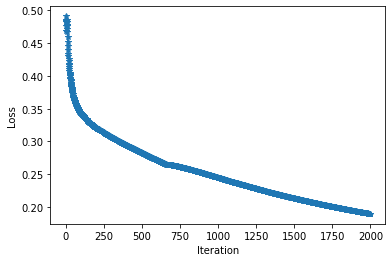

array([0.        , 0.4691259 , 0.47677228, ..., 0.18933263, 0.18928762,
       0.1892481 ])

In [31]:
train_setup(net, lr=0.001, n_batches=2000, batch_size = 64, display_freq=10, device = device_gpu)#n_batches=2000

In [36]:
out = infer(net, 'INDIA', device_gpu) #after training
print(len(out))

['इ', 'ं', 'ड', 'ि', 'य', 'ा', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
30


In [43]:
out = infer(net, 'CLASS', device_gpu) 


['क', '्', 'ल', 'ा', 'स', 'स', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']


### Encoder decoder model with Attention

In [66]:
class Transliteration_EncoderDecoder_Attention(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, verbose=False):
        super(Transliteration_EncoderDecoder_Attention, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        self.U = nn.Linear(self.hidden_size, self.hidden_size)
        self.W = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, 1)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)   
        
        self.verbose = verbose
        
    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        
        # encoder
        encoder_outputs, hidden = self.encoder_rnn_cell(input)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
        
        if self.verbose:
            print('Encoder output', encoder_outputs.shape)
        
        # decoder
        decoder_state = hidden
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        
        outputs = []
        U = self.U(encoder_outputs)
        
        if self.verbose:
            print('Decoder state', decoder_state.shape)
            print('Decoder intermediate input', decoder_input.shape)
            print('U * Encoder output', U.shape)
        
        for i in range(max_output_chars):
            
            W = self.W(decoder_state.view(1, -1).repeat(encoder_outputs.shape[0], 1))
            V = self.attn(torch.tanh(U + W))
            attn_weights = F.softmax(V.view(1, -1), dim = 1) 
            
            if self.verbose:
                print('W * Decoder state', W.shape)
                print('V', V.shape)
                print('Attn', attn_weights.shape)
            
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            
            embedding = self.out2hidden(decoder_input)
            decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0)
            
            if self.verbose:
                print('Attn LC', attn_applied.shape)
                print('Decoder input', decoder_input.shape)
                
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            
            if self.verbose:
                print('Decoder intermediate output', out.shape)
                
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            
            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False
            
            max_idx = torch.argmax(out, 2, keepdim=True)
            # print(max_idx)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1) 
            
            decoder_input = one_hot.detach()
            
        return outputs

In [67]:
net_attn = Transliteration_EncoderDecoder_Attention(len(eng_alphabets), 256, len(hindi_alphabets), verbose=True)

#### Compute Loss

Iteration 1999 Loss 0.1394243836402893


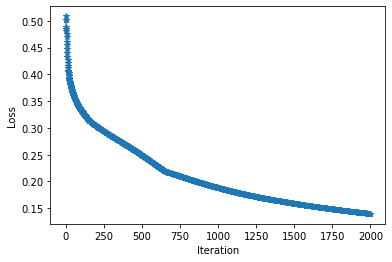

In [68]:
loss_history = train_setup(net_attn, lr=0.001, n_batches=2000, batch_size = 64, display_freq=10, device = device_gpu) #n_batches=2000n

### Inference

In [74]:
out = infer(net_attn, 'CLASS', device_gpu) #after training


['क', '्', 'ल', 'ा', 'स', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']


In [71]:
out = infer(net, 'CROCODILE', device_gpu)#Encoder and decoder without attention

['क', '्', 'र', 'ो', 'क', '्', 'ल', 'ि', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']


In [70]:
out = infer(net_attn, 'CROCODILE', device_gpu) #Encoder and decoder with attention - Better at predicting

['क', '्', 'र', 'ो', 'क', 'ो', 'ड', 'ि', 'ल', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
